In [1]:
import torch
from torch import nn, optim
from torchvision import datasets, transforms
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.utils import save_image
from math import log2
import numpy as np
import os
from tqdm import tqdm
import torchvision.datasets as dset
import matplotlib.pyplot as plt
import random

In [2]:
def seed_everything(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
seed_everything()

In [3]:
EXPERIMENT_NAME         = "test"
DATASET                 = "2D_assets" #2D_assets, all_assets or bulbapedia  ###needs to have a subfolder(s) which contains the data
START_TRAIN_AT_IMG_SIZE = 4
DEVICE                  = "cuda" if torch.cuda.is_available() else "mps"
LEARNING_RATE           = 1e-3
BATCH_SIZES             = [32, 32, 32, 16, 16, 16] #you can use [32, 32, 32, 16, 16, 16, 16, 8, 4] for example if you want to train until 1024x1024, but again this numbers depend on your vram
image_size              = 128
CHANNELS_IMG            = 3
Z_DIM                   = 256  # should be 512 in original paper
IN_CHANNELS             = 256  # should be 512 in original paper
LAMBDA_GP               = 10
PROGRESSIVE_EPOCHS      = [30] * len(BATCH_SIZES)

LOAD_MODEL              = False
SAVED_PATH              = "outputs/test_75_training_128x128/"
IMAGE_SIZE_SAVED            = 16

In [4]:
amount_folders = len([name for name in os.listdir('outputs') if os.path.isdir(os.path.join('outputs', name))])

EXPERIMENT_NAME = f"{EXPERIMENT_NAME}_{amount_folders}_{DATASET}_{image_size}x{image_size}"
print(EXPERIMENT_NAME)

OUTPUT_DIR = f'outputs/{EXPERIMENT_NAME}'

test_1_2D_assets_128x128


In [5]:
def get_loader(image_size):
    batch_size = BATCH_SIZES[int(log2(image_size / 4))]
    dataset = dset.ImageFolder(root=f"dataset/{DATASET}",
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
    # Create the dataloader
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                             shuffle=True, num_workers=2)
    return dataloader, dataset

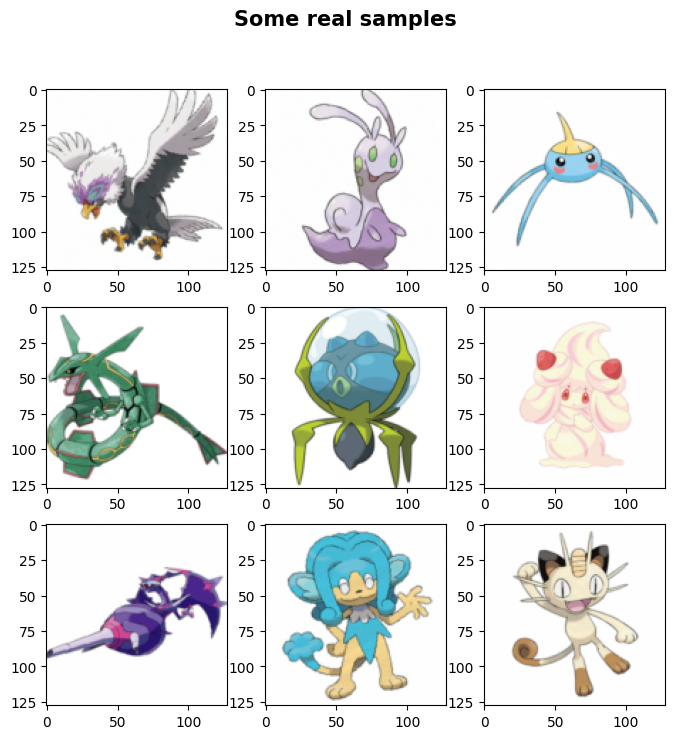

In [6]:
def check_loader():
    loader,_ = get_loader(128)
    cloth ,_ = next(iter(loader))
    _, ax    = plt.subplots(3,3, figsize=(8,8))
    plt.suptitle('Some real samples', fontsize=15, fontweight='bold')
    ind = 0 
    for k in range(3):
        for kk in range(3):
            ind += 1
            ax[k][kk].imshow((cloth[ind].permute(1,2,0)+1)/2) 
check_loader()

In [7]:
factors = [1, 1, 1, 1, 1 / 2, 1 / 4, 1 / 8, 1 / 16, 1 / 32]

In [8]:
class WSConv2d(nn.Module):

    def __init__(
        self, in_channels, out_channels, kernel_size=3, stride=1, padding=1,
    ):
        super(WSConv2d, self).__init__()
        self.conv      = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.scale     = (2 / (in_channels * (kernel_size ** 2))) ** 0.5
        self.bias      = self.conv.bias #Copy the bias of the current column layer
        self.conv.bias = None      #Remove the bias

        # initialize conv layer
        nn.init.normal_(self.conv.weight)
        nn.init.zeros_(self.bias)

    def forward(self, x):
        return self.conv(x * self.scale) + self.bias.view(1, self.bias.shape[0], 1, 1)

In [9]:
class PixelNorm(nn.Module):
    def __init__(self):
        super(PixelNorm, self).__init__()
        self.epsilon = 1e-8

    def forward(self, x):
        return x / torch.sqrt(torch.mean(x ** 2, dim=1, keepdim=True) + self.epsilon)

In [10]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, use_pixelnorm=True):
        super(ConvBlock, self).__init__()
        self.use_pn = use_pixelnorm
        self.conv1  = WSConv2d(in_channels, out_channels)
        self.conv2  = WSConv2d(out_channels, out_channels)
        self.leaky  = nn.LeakyReLU(0.2)
        self.pn     = PixelNorm()

    def forward(self, x):
        x = self.leaky(self.conv1(x))
        x = self.pn(x) if self.use_pn else x
        x = self.leaky(self.conv2(x))
        x = self.pn(x) if self.use_pn else x
        return x

In [11]:
class Generator(nn.Module):
    def __init__(self, z_dim, in_channels, img_channels=3):
        super(Generator, self).__init__()

        # initial takes 1x1 -> 4x4
        self.initial = nn.Sequential(
            PixelNorm(),
            nn.ConvTranspose2d(z_dim, in_channels, 4, 1, 0),
            nn.LeakyReLU(0.2),
            WSConv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            PixelNorm(),
        )

        self.initial_rgb = WSConv2d(
            in_channels, img_channels, kernel_size=1, stride=1, padding=0
        )
        self.prog_blocks, self.rgb_layers = (
            nn.ModuleList([]),
            nn.ModuleList([self.initial_rgb]),
        )

        for i in range(
            len(factors) - 1
        ):  # -1 to prevent index error because of factors[i+1]
            conv_in_c  = int(in_channels * factors[i])
            conv_out_c = int(in_channels * factors[i + 1])
            self.prog_blocks.append(ConvBlock(conv_in_c, conv_out_c))
            self.rgb_layers.append(
                WSConv2d(conv_out_c, img_channels, kernel_size=1, stride=1, padding=0)
            )

    def fade_in(self, alpha, upscaled, generated):
        # alpha should be scalar within [0, 1], and upscale.shape == generated.shape
        return torch.tanh(alpha * generated + (1 - alpha) * upscaled)

    def forward(self, x, alpha, steps):
        out = self.initial(x)

        if steps == 0:
            return self.initial_rgb(out)

        for step in range(steps):
            upscaled = F.interpolate(out, scale_factor=2, mode="nearest")
            out = self.prog_blocks[step](upscaled)

        # The number of channels in upscale will stay the same, while
        # out which has moved through prog_blocks might change. To ensure
        # we can convert both to rgb we use different rgb_layers
        # (steps-1) and steps for upscaled, out respectively
        final_upscaled = self.rgb_layers[steps - 1](upscaled)
        final_out = self.rgb_layers[steps](out)
        return self.fade_in(alpha, final_upscaled, final_out)

In [12]:
class Discriminator(nn.Module):
    def __init__(self, in_channels, img_channels=3):
        super(Discriminator, self).__init__()
        self.prog_blocks, self.rgb_layers = nn.ModuleList([]), nn.ModuleList([])
        self.leaky = nn.LeakyReLU(0.2)

        # here we work back ways from factors because the discriminator
        # should be mirrored from the generator. So the first prog_block and
        # rgb layer we append will work for input size 1024x1024, then 512->256-> etc
        for i in range(len(factors) - 1, 0, -1):
            conv_in = int(in_channels * factors[i])
            conv_out = int(in_channels * factors[i - 1])
            self.prog_blocks.append(ConvBlock(conv_in, conv_out, use_pixelnorm=False))
            self.rgb_layers.append(
                WSConv2d(img_channels, conv_in, kernel_size=1, stride=1, padding=0)
            )

        # perhaps confusing name "initial_rgb" this is just the RGB layer for 4x4 input size
        # did this to "mirror" the generator initial_rgb
        self.initial_rgb = WSConv2d(
            img_channels, in_channels, kernel_size=1, stride=1, padding=0
        )
        self.rgb_layers.append(self.initial_rgb)
        self.avg_pool = nn.AvgPool2d(
            kernel_size=2, stride=2
        )  # down sampling using avg pool

        # this is the block for 4x4 input size
        self.final_block = nn.Sequential(
            # +1 to in_channels because we concatenate from MiniBatch std
            WSConv2d(in_channels + 1, in_channels, kernel_size=3, padding=1),
            nn.LeakyReLU(0.2),
            WSConv2d(in_channels, in_channels, kernel_size=4, padding=0, stride=1),
            nn.LeakyReLU(0.2),
            WSConv2d(
                in_channels, 1, kernel_size=1, padding=0, stride=1
            ),  # we use this instead of linear layer
        )

    def fade_in(self, alpha, downscaled, out):
        """Used to fade in downscaled using avg pooling and output from CNN"""
        # alpha should be scalar within [0, 1], and upscale.shape == generated.shape
        return alpha * out + (1 - alpha) * downscaled

    def minibatch_std(self, x):
        batch_statistics = (
            torch.std(x, dim=0).mean().repeat(x.shape[0], 1, x.shape[2], x.shape[3])
        )
        # we take the std for each example (across all channels, and pixels) then we repeat it
        # for a single channel and concatenate it with the image. In this way the discriminator
        # will get information about the variation in the batch/image
        return torch.cat([x, batch_statistics], dim=1)

    def forward(self, x, alpha, steps):
        # where we should start in the list of prog_blocks, maybe a bit confusing but
        # the last is for the 4x4. So example let's say steps=1, then we should start
        # at the second to last because input_size will be 8x8. If steps==0 we just
        # use the final block
        cur_step = len(self.prog_blocks) - steps

        # convert from rgb as initial step, this will depend on
        # the image size (each will have it's on rgb layer)
        out = self.leaky(self.rgb_layers[cur_step](x))

        if steps == 0:  # i.e, image is 4x4
            out = self.minibatch_std(out)
            return self.final_block(out).view(out.shape[0], -1)

        # because prog_blocks might change the channels, for down scale we use rgb_layer
        # from previous/smaller size which in our case correlates to +1 in the indexing
        downscaled = self.leaky(self.rgb_layers[cur_step + 1](self.avg_pool(x)))
        out = self.avg_pool(self.prog_blocks[cur_step](out))

        # the fade_in is done first between the downscaled and the input
        # this is opposite from the generator
        out = self.fade_in(alpha, downscaled, out)

        for step in range(cur_step + 1, len(self.prog_blocks)):
            out = self.prog_blocks[step](out)
            out = self.avg_pool(out)

        out = self.minibatch_std(out)
        return self.final_block(out).view(out.shape[0], -1)

In [13]:
def gradient_penalty(critic, real, fake, alpha, train_step, device="mps"):
    BATCH_SIZE, C, H, W = real.shape
    beta = torch.rand((BATCH_SIZE, 1, 1, 1)).repeat(1, C, H, W).to(device)
    interpolated_images = real * beta + fake.detach() * (1 - beta)
    interpolated_images.requires_grad_(True)

    # Calculate critic scores
    mixed_scores = critic(interpolated_images, alpha, train_step)
 
    # Take the gradient of the scores with respect to the images
    gradient = torch.autograd.grad(
        inputs=interpolated_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True,
    )[0]
    gradient = gradient.view(gradient.shape[0], -1)
    gradient_norm = gradient.norm(2, dim=1)
    gradient_penalty = torch.mean((gradient_norm - 1) ** 2)
    return gradient_penalty

In [14]:
def generate_examples(gen, steps, n=100, path='saved_examples'):

    gen.eval()
    alpha = 1.0
    for i in range(n):
        with torch.no_grad():
            noise = torch.randn(1, Z_DIM, 1, 1).to(DEVICE)
            img = gen(noise, alpha, steps)
            if not os.path.exists(os.path.join(path,f'step{steps}')):
                os.makedirs(os.path.join(path,f'step{steps}'))
            save_image(img*0.5+0.5, os.path.join(path,f"step{steps}/img_{i}.png"))
    gen.train()

In [15]:
torch.backends.cudnn.benchmarks = True

In [16]:
def train_fn(
    critic,
    gen,
    loader,
    dataset,
    step,
    alpha,
    opt_critic,
    opt_gen,
):
    loop = tqdm(loader, leave=True)
    for batch_idx, (real, _) in enumerate(loop):
        real = real.to(DEVICE)
        cur_batch_size = real.shape[0]

        # Train Critic: max E[critic(real)] - E[critic(fake)] <-> min -E[critic(real)] + E[critic(fake)]
        # which is equivalent to minimizing the negative of the expression
        noise = torch.randn(cur_batch_size, Z_DIM, 1, 1).to(DEVICE)

        fake = gen(noise, alpha, step)
        critic_real = critic(real, alpha, step)
        critic_fake = critic(fake.detach(), alpha, step)
        gp = gradient_penalty(critic, real, fake, alpha, step, device=DEVICE)
        loss_critic = (
            -(torch.mean(critic_real) - torch.mean(critic_fake))
            + LAMBDA_GP * gp
            + (0.001 * torch.mean(critic_real ** 2))
        )

        critic.zero_grad()
        loss_critic.backward()
        opt_critic.step()

        # Train Generator: max E[critic(gen_fake)] <-> min -E[critic(gen_fake)]
        gen_fake = critic(fake, alpha, step)
        loss_gen = -torch.mean(gen_fake)

        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()

        # Update alpha and ensure less than 1
        alpha += cur_batch_size / (
            (PROGRESSIVE_EPOCHS[step] * 0.5) * len(dataset)
        )
        alpha = min(alpha, 1)

        loop.set_postfix(
            gp=gp.item(),
            loss_critic=loss_critic.item(),
        )
        

    return alpha

In [17]:
# initialize gen and disc, note: discriminator we called critic,
# according to WGAN paper (since it no longer outputs between [0, 1])
gen = Generator(
    Z_DIM, IN_CHANNELS, img_channels=CHANNELS_IMG
).to(DEVICE)

critic = Discriminator(
    IN_CHANNELS, img_channels=CHANNELS_IMG
).to(DEVICE)

if LOAD_MODEL:
    gen.load_state_dict(torch.load(SAVED_PATH + f'generator_{IMAGE_SIZE_SAVED}.pth'))
    critic.load_state_dict(torch.load(SAVED_PATH + f'critic_{IMAGE_SIZE_SAVED}.pth'))
    START_TRAIN_AT_IMG_SIZE = IMAGE_SIZE_SAVED*2

# initialize optimizers
opt_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0.0, 0.99))
opt_critic = optim.Adam(
    critic.parameters(), lr=LEARNING_RATE, betas=(0.0, 0.99)
)


gen.train()
critic.train()

os.makedirs(f'outputs/{EXPERIMENT_NAME}', exist_ok=True)

step = int(log2(START_TRAIN_AT_IMG_SIZE / 4))
try:
    for num_epochs in PROGRESSIVE_EPOCHS[step:]: #reduce iteration based on start image size (required if model loaded from drive)
        alpha = 1e-5
        loader, dataset = get_loader(4 * 2 ** step) # 4->0, 8->1, 16->2, 32->3, 64 -> 4
        print(f"Current image size: {4 * 2 ** step}")

        for epoch in range(num_epochs):
            print(f"Epoch [{epoch+1}/{num_epochs}]")
            alpha = train_fn(
                critic,
                gen,
                loader,
                dataset,
                step,
                alpha,
                opt_critic,
                opt_gen
            )
        
        generate_examples(gen, step, n=100, path=f'outputs/{EXPERIMENT_NAME}')

        torch.save(gen.state_dict(), f'outputs/{EXPERIMENT_NAME}/generator_{4 * 2 ** step}.pth')
        torch.save(critic.state_dict(), f'outputs/{EXPERIMENT_NAME}/critic_{4 * 2 ** step}.pth')

        step += 1  # Progress to the next image size
except KeyboardInterrupt:
    print("Training interrupted by user")
    torch.save(gen.state_dict(), f'outputs/{EXPERIMENT_NAME}/generator_interrupted_{4 * 2 ** step}.pth')
    torch.save(critic.state_dict(), f'outputs/{EXPERIMENT_NAME}/critic_interrupted{4 * 2 ** step}.pth')
    print("Model state saved successfully on interruption.")
finally:
    generate_examples(gen, step, n=100, path=f'outputs/{EXPERIMENT_NAME}_interrupted')
    print("Cleaning up resources...")

Current image size: 4
Epoch [1/30]


100%|██████████| 207/207 [00:15<00:00, 13.23it/s, gp=0.0272, loss_critic=-0.617]


Epoch [2/30]


100%|██████████| 207/207 [00:07<00:00, 27.65it/s, gp=0.0062, loss_critic=-0.404] 


Epoch [3/30]


100%|██████████| 207/207 [00:07<00:00, 27.65it/s, gp=0.00317, loss_critic=-0.551] 


Epoch [4/30]


100%|██████████| 207/207 [00:07<00:00, 27.88it/s, gp=0.00441, loss_critic=-0.101] 


Epoch [5/30]


100%|██████████| 207/207 [00:07<00:00, 28.01it/s, gp=0.01, loss_critic=0.155]      


Epoch [6/30]


100%|██████████| 207/207 [00:07<00:00, 27.99it/s, gp=0.0032, loss_critic=0.0352]   


Epoch [7/30]


100%|██████████| 207/207 [00:07<00:00, 27.85it/s, gp=0.00611, loss_critic=0.0529] 


Epoch [8/30]


100%|██████████| 207/207 [00:07<00:00, 27.99it/s, gp=0.00914, loss_critic=0.0357]  


Epoch [9/30]


100%|██████████| 207/207 [00:07<00:00, 28.03it/s, gp=0.00457, loss_critic=-0.197]  


Epoch [10/30]


100%|██████████| 207/207 [00:07<00:00, 27.85it/s, gp=0.00877, loss_critic=0.0343]  


Epoch [11/30]


100%|██████████| 207/207 [00:07<00:00, 28.07it/s, gp=0.0134, loss_critic=-0.00871] 


Epoch [12/30]


100%|██████████| 207/207 [00:07<00:00, 28.03it/s, gp=0.00131, loss_critic=0.133]    


Epoch [13/30]


100%|██████████| 207/207 [00:07<00:00, 27.98it/s, gp=0.00602, loss_critic=0.0338]   


Epoch [14/30]


100%|██████████| 207/207 [00:07<00:00, 27.92it/s, gp=5.59e-6, loss_critic=-0.169]  


Epoch [15/30]


100%|██████████| 207/207 [00:07<00:00, 28.08it/s, gp=6.17e-5, loss_critic=-0.0773] 


Epoch [16/30]


100%|██████████| 207/207 [00:07<00:00, 28.05it/s, gp=0.00161, loss_critic=0.112]    


Epoch [17/30]


100%|██████████| 207/207 [00:07<00:00, 28.01it/s, gp=0.00244, loss_critic=0.0542]   


Epoch [18/30]


100%|██████████| 207/207 [00:07<00:00, 27.97it/s, gp=0.00192, loss_critic=-0.234]   


Epoch [19/30]


100%|██████████| 207/207 [00:07<00:00, 28.04it/s, gp=0.000663, loss_critic=-0.102] 


Epoch [20/30]


100%|██████████| 207/207 [00:07<00:00, 28.02it/s, gp=0.00609, loss_critic=0.292]   


Epoch [21/30]


100%|██████████| 207/207 [00:07<00:00, 27.74it/s, gp=0.00319, loss_critic=-0.441]   


Epoch [22/30]


100%|██████████| 207/207 [00:07<00:00, 28.01it/s, gp=0.00412, loss_critic=-0.123]  


Epoch [23/30]


100%|██████████| 207/207 [00:07<00:00, 28.13it/s, gp=0.00179, loss_critic=0.2]     


Epoch [24/30]


100%|██████████| 207/207 [00:07<00:00, 28.24it/s, gp=0.00496, loss_critic=0.218]   


Epoch [25/30]


100%|██████████| 207/207 [00:07<00:00, 28.18it/s, gp=0.000441, loss_critic=-0.13]  


Epoch [26/30]


100%|██████████| 207/207 [00:07<00:00, 28.24it/s, gp=0.00312, loss_critic=-0.0411]  


Epoch [27/30]


100%|██████████| 207/207 [00:07<00:00, 28.08it/s, gp=0.000343, loss_critic=-0.016]  


Epoch [28/30]


100%|██████████| 207/207 [00:07<00:00, 28.17it/s, gp=0.00285, loss_critic=0.152]   


Epoch [29/30]


100%|██████████| 207/207 [00:07<00:00, 28.28it/s, gp=0.0312, loss_critic=0.114]    


Epoch [30/30]


100%|██████████| 207/207 [00:07<00:00, 27.99it/s, gp=0.00325, loss_critic=-0.127]   


Current image size: 8
Epoch [1/30]


100%|██████████| 207/207 [00:09<00:00, 22.10it/s, gp=0.00526, loss_critic=-0.637]  


Epoch [2/30]


100%|██████████| 207/207 [00:09<00:00, 22.04it/s, gp=0.0194, loss_critic=-0.28]   


Epoch [3/30]


100%|██████████| 207/207 [00:09<00:00, 22.08it/s, gp=0.00165, loss_critic=0.688]   


Epoch [4/30]


100%|██████████| 207/207 [00:09<00:00, 22.08it/s, gp=0.00673, loss_critic=0.939]   


Epoch [5/30]


100%|██████████| 207/207 [00:09<00:00, 21.95it/s, gp=0.00125, loss_critic=1.16]    


Epoch [6/30]


100%|██████████| 207/207 [00:09<00:00, 21.84it/s, gp=0.00524, loss_critic=-0.395]  


Epoch [7/30]


100%|██████████| 207/207 [00:09<00:00, 22.07it/s, gp=0.00021, loss_critic=0.161]  


Epoch [8/30]


100%|██████████| 207/207 [00:09<00:00, 22.42it/s, gp=0.00442, loss_critic=-0.096]  


Epoch [9/30]


100%|██████████| 207/207 [00:09<00:00, 22.19it/s, gp=0.00313, loss_critic=-0.493]  


Epoch [10/30]


100%|██████████| 207/207 [00:09<00:00, 22.07it/s, gp=0.00108, loss_critic=-0.162]  


Epoch [11/30]


100%|██████████| 207/207 [00:09<00:00, 22.28it/s, gp=0.00571, loss_critic=0.771]   


Epoch [12/30]


100%|██████████| 207/207 [00:09<00:00, 22.48it/s, gp=0.00257, loss_critic=0.233]    


Epoch [13/30]


100%|██████████| 207/207 [00:09<00:00, 22.50it/s, gp=0.00873, loss_critic=0.0904] 


Epoch [14/30]


100%|██████████| 207/207 [00:09<00:00, 22.50it/s, gp=2.62e-5, loss_critic=0.468]   


Epoch [15/30]


100%|██████████| 207/207 [00:09<00:00, 22.60it/s, gp=0.00392, loss_critic=-0.499] 


Epoch [16/30]


100%|██████████| 207/207 [00:09<00:00, 22.56it/s, gp=0.0104, loss_critic=-0.0891]  


Epoch [17/30]


100%|██████████| 207/207 [00:09<00:00, 22.00it/s, gp=0.00513, loss_critic=1.1]    


Epoch [18/30]


100%|██████████| 207/207 [00:09<00:00, 21.43it/s, gp=0.0162, loss_critic=-0.0981]  


Epoch [19/30]


100%|██████████| 207/207 [00:09<00:00, 20.74it/s, gp=0.00695, loss_critic=0.482]    


Epoch [20/30]


100%|██████████| 207/207 [00:09<00:00, 21.71it/s, gp=0.0145, loss_critic=-0.447]   


Epoch [21/30]


100%|██████████| 207/207 [00:09<00:00, 21.05it/s, gp=0.0305, loss_critic=0.961]    


Epoch [22/30]


100%|██████████| 207/207 [00:10<00:00, 20.47it/s, gp=0.000258, loss_critic=0.218]  


Epoch [23/30]


100%|██████████| 207/207 [00:09<00:00, 22.13it/s, gp=0.00129, loss_critic=0.186]    


Epoch [24/30]


100%|██████████| 207/207 [00:09<00:00, 21.98it/s, gp=0.00482, loss_critic=1.13]    


Epoch [25/30]


100%|██████████| 207/207 [00:09<00:00, 22.08it/s, gp=0.00254, loss_critic=0.0705]  


Epoch [26/30]


100%|██████████| 207/207 [00:09<00:00, 22.08it/s, gp=0.0012, loss_critic=0.136]    


Epoch [27/30]


100%|██████████| 207/207 [00:09<00:00, 21.98it/s, gp=0.0112, loss_critic=1.09]     


Epoch [28/30]


100%|██████████| 207/207 [00:09<00:00, 22.10it/s, gp=0.0057, loss_critic=0.583]    


Epoch [29/30]


100%|██████████| 207/207 [00:09<00:00, 21.37it/s, gp=0.00233, loss_critic=0.703]   


Epoch [30/30]


100%|██████████| 207/207 [00:09<00:00, 21.14it/s, gp=0.00718, loss_critic=-0.219]  


Current image size: 16
Epoch [1/30]


100%|██████████| 207/207 [00:20<00:00,  9.94it/s, gp=0.00521, loss_critic=-1.55]  


Epoch [2/30]


100%|██████████| 207/207 [00:20<00:00, 10.14it/s, gp=0.00979, loss_critic=0.372]  


Epoch [3/30]


100%|██████████| 207/207 [00:20<00:00,  9.90it/s, gp=0.000633, loss_critic=0.266]   


Epoch [4/30]


100%|██████████| 207/207 [00:20<00:00, 10.13it/s, gp=0.00218, loss_critic=0.347]   


Epoch [5/30]


100%|██████████| 207/207 [00:20<00:00, 10.11it/s, gp=0.01, loss_critic=-0.462]     


Epoch [6/30]


100%|██████████| 207/207 [00:20<00:00, 10.23it/s, gp=0.00214, loss_critic=-1.32]   


Epoch [7/30]


100%|██████████| 207/207 [00:20<00:00, 10.27it/s, gp=0.0235, loss_critic=-2.1]     


Epoch [8/30]


100%|██████████| 207/207 [00:20<00:00, 10.21it/s, gp=0.0128, loss_critic=3.71]     


Epoch [9/30]


100%|██████████| 207/207 [00:20<00:00, 10.14it/s, gp=0.0114, loss_critic=1.48]    


Epoch [10/30]


100%|██████████| 207/207 [00:20<00:00, 10.12it/s, gp=0.0166, loss_critic=1.35]     


Epoch [11/30]


100%|██████████| 207/207 [00:20<00:00, 10.19it/s, gp=0.000327, loss_critic=1.02]  


Epoch [12/30]


100%|██████████| 207/207 [00:20<00:00, 10.16it/s, gp=0.0077, loss_critic=0.0889]  


Epoch [13/30]


100%|██████████| 207/207 [00:20<00:00, 10.05it/s, gp=0.000825, loss_critic=-0.675]


Epoch [14/30]


100%|██████████| 207/207 [00:20<00:00,  9.96it/s, gp=0.00716, loss_critic=-1.16]  


Epoch [15/30]


100%|██████████| 207/207 [00:20<00:00,  9.98it/s, gp=6.1e-5, loss_critic=0.163]    


Epoch [16/30]


100%|██████████| 207/207 [00:20<00:00, 10.15it/s, gp=0.000707, loss_critic=-0.296] 


Epoch [17/30]


100%|██████████| 207/207 [00:20<00:00, 10.20it/s, gp=0.0105, loss_critic=-0.891]   


Epoch [18/30]


100%|██████████| 207/207 [00:20<00:00, 10.09it/s, gp=0.00165, loss_critic=0.069]   


Epoch [19/30]


100%|██████████| 207/207 [00:20<00:00, 10.14it/s, gp=0.00102, loss_critic=-0.382] 


Epoch [20/30]


100%|██████████| 207/207 [00:20<00:00, 10.06it/s, gp=4.94e-5, loss_critic=0.952]   


Epoch [21/30]


100%|██████████| 207/207 [00:20<00:00,  9.97it/s, gp=0.00405, loss_critic=-0.0324] 


Epoch [22/30]


100%|██████████| 207/207 [00:20<00:00, 10.15it/s, gp=0.00501, loss_critic=0.593]   


Epoch [23/30]


100%|██████████| 207/207 [00:20<00:00, 10.19it/s, gp=0.0034, loss_critic=0.704]    


Epoch [24/30]


100%|██████████| 207/207 [00:20<00:00, 10.22it/s, gp=0.0209, loss_critic=0.138]    


Epoch [25/30]


100%|██████████| 207/207 [00:20<00:00,  9.96it/s, gp=0.000817, loss_critic=-0.326]


Epoch [26/30]


100%|██████████| 207/207 [00:20<00:00, 10.02it/s, gp=0.00745, loss_critic=0.88]    


Epoch [27/30]


100%|██████████| 207/207 [00:20<00:00, 10.03it/s, gp=0.00169, loss_critic=0.372]   


Epoch [28/30]


100%|██████████| 207/207 [00:20<00:00, 10.16it/s, gp=0.000551, loss_critic=1.14]  


Epoch [29/30]


100%|██████████| 207/207 [00:20<00:00, 10.20it/s, gp=0.00676, loss_critic=-1.35]    


Epoch [30/30]


100%|██████████| 207/207 [00:20<00:00, 10.17it/s, gp=0.000723, loss_critic=-2.91] 


Current image size: 32
Epoch [1/30]


100%|██████████| 413/413 [01:04<00:00,  6.36it/s, gp=0.0118, loss_critic=-4.07]   


Epoch [2/30]


100%|██████████| 413/413 [01:04<00:00,  6.37it/s, gp=0.0144, loss_critic=0.324]  


Epoch [3/30]


100%|██████████| 413/413 [01:04<00:00,  6.42it/s, gp=0.00644, loss_critic=2.34]   


Epoch [4/30]


100%|██████████| 413/413 [01:04<00:00,  6.40it/s, gp=0.0265, loss_critic=-1.07]   


Epoch [5/30]


100%|██████████| 413/413 [01:06<00:00,  6.20it/s, gp=0.00434, loss_critic=-2.3]    


Epoch [6/30]


100%|██████████| 413/413 [01:04<00:00,  6.38it/s, gp=0.00794, loss_critic=0.497]    


Epoch [7/30]


100%|██████████| 413/413 [01:04<00:00,  6.40it/s, gp=0.0184, loss_critic=-0.128]   


Epoch [8/30]


100%|██████████| 413/413 [01:04<00:00,  6.40it/s, gp=0.0162, loss_critic=0.178]    


Epoch [9/30]


100%|██████████| 413/413 [01:05<00:00,  6.32it/s, gp=0.00903, loss_critic=-1.05]   


Epoch [10/30]


100%|██████████| 413/413 [01:04<00:00,  6.38it/s, gp=0.00671, loss_critic=2.84]   


Epoch [11/30]


100%|██████████| 413/413 [01:04<00:00,  6.39it/s, gp=0.000558, loss_critic=1.58]  


Epoch [12/30]


100%|██████████| 413/413 [01:04<00:00,  6.38it/s, gp=0.137, loss_critic=-3.21]     


Epoch [13/30]


100%|██████████| 413/413 [01:04<00:00,  6.37it/s, gp=0.0131, loss_critic=-0.626]   


Epoch [14/30]


100%|██████████| 413/413 [01:05<00:00,  6.31it/s, gp=0.00969, loss_critic=-1.38]   


Epoch [15/30]


100%|██████████| 413/413 [01:04<00:00,  6.38it/s, gp=0.00881, loss_critic=2.4]     


Epoch [16/30]


100%|██████████| 413/413 [01:04<00:00,  6.38it/s, gp=0.0196, loss_critic=1.66]     


Epoch [17/30]


100%|██████████| 413/413 [01:04<00:00,  6.38it/s, gp=0.0137, loss_critic=0.892]    


Epoch [18/30]


100%|██████████| 413/413 [01:04<00:00,  6.37it/s, gp=0.0118, loss_critic=-0.278]   


Epoch [19/30]


100%|██████████| 413/413 [01:04<00:00,  6.40it/s, gp=0.0114, loss_critic=0.594]    


Epoch [20/30]


100%|██████████| 413/413 [01:04<00:00,  6.41it/s, gp=0.0322, loss_critic=0.994]    


Epoch [21/30]


100%|██████████| 413/413 [01:04<00:00,  6.39it/s, gp=0.00956, loss_critic=-1.27]  


Epoch [22/30]


100%|██████████| 413/413 [01:05<00:00,  6.35it/s, gp=0.00342, loss_critic=-1.55]   


Epoch [23/30]


100%|██████████| 413/413 [01:04<00:00,  6.41it/s, gp=0.00839, loss_critic=-0.147]  


Epoch [24/30]


100%|██████████| 413/413 [01:05<00:00,  6.32it/s, gp=0.0215, loss_critic=-0.243]   


Epoch [25/30]


100%|██████████| 413/413 [01:04<00:00,  6.37it/s, gp=0.0101, loss_critic=0.482]   


Epoch [26/30]


100%|██████████| 413/413 [01:04<00:00,  6.39it/s, gp=0.0222, loss_critic=-1.05]    


Epoch [27/30]


100%|██████████| 413/413 [01:05<00:00,  6.35it/s, gp=0.0214, loss_critic=-1.44]   


Epoch [28/30]


100%|██████████| 413/413 [01:05<00:00,  6.32it/s, gp=0.017, loss_critic=-1.69]    


Epoch [29/30]


100%|██████████| 413/413 [01:05<00:00,  6.34it/s, gp=0.000166, loss_critic=-0.487] 


Epoch [30/30]


100%|██████████| 413/413 [01:04<00:00,  6.37it/s, gp=0.0703, loss_critic=-2.42]    


Current image size: 64
Epoch [1/30]


100%|██████████| 413/413 [02:55<00:00,  2.35it/s, gp=0.17, loss_critic=-5.97]     


Epoch [2/30]


100%|██████████| 413/413 [02:55<00:00,  2.36it/s, gp=0.000102, loss_critic=3.89]  


Epoch [3/30]


100%|██████████| 413/413 [02:57<00:00,  2.33it/s, gp=0.109, loss_critic=-1.39]    


Epoch [4/30]


100%|██████████| 413/413 [02:56<00:00,  2.34it/s, gp=0.0626, loss_critic=1.01]    


Epoch [5/30]


100%|██████████| 413/413 [02:55<00:00,  2.35it/s, gp=0.055, loss_critic=-3.7]      


Epoch [6/30]


100%|██████████| 413/413 [03:00<00:00,  2.28it/s, gp=0.0881, loss_critic=5.06]    


Epoch [7/30]


100%|██████████| 413/413 [02:59<00:00,  2.30it/s, gp=0.0254, loss_critic=-0.645] 


Epoch [8/30]


100%|██████████| 413/413 [02:58<00:00,  2.32it/s, gp=0.0892, loss_critic=-2.34]   


Epoch [9/30]


100%|██████████| 413/413 [02:57<00:00,  2.33it/s, gp=0.116, loss_critic=7.33]    


Epoch [10/30]


100%|██████████| 413/413 [02:54<00:00,  2.36it/s, gp=0.0606, loss_critic=4.14]    


Epoch [11/30]


100%|██████████| 413/413 [02:54<00:00,  2.37it/s, gp=0.0242, loss_critic=-2.26]  


Epoch [12/30]


100%|██████████| 413/413 [02:54<00:00,  2.37it/s, gp=0.0682, loss_critic=-10.8]  


Epoch [13/30]


100%|██████████| 413/413 [02:54<00:00,  2.37it/s, gp=0.061, loss_critic=1.06]    


Epoch [14/30]


100%|██████████| 413/413 [02:54<00:00,  2.37it/s, gp=0.145, loss_critic=-3.27]   


Epoch [15/30]


100%|██████████| 413/413 [02:54<00:00,  2.37it/s, gp=0.0217, loss_critic=-2.15]  


Epoch [16/30]


100%|██████████| 413/413 [02:53<00:00,  2.38it/s, gp=0.0549, loss_critic=-8.06]   


Epoch [17/30]


100%|██████████| 413/413 [02:53<00:00,  2.38it/s, gp=0.0555, loss_critic=-4.58]   


Epoch [18/30]


100%|██████████| 413/413 [02:53<00:00,  2.38it/s, gp=0.202, loss_critic=3.25]    


Epoch [19/30]


100%|██████████| 413/413 [02:53<00:00,  2.38it/s, gp=0.0844, loss_critic=-2.82]  


Epoch [20/30]


100%|██████████| 413/413 [02:53<00:00,  2.38it/s, gp=0.0804, loss_critic=-0.977]  


Epoch [21/30]


100%|██████████| 413/413 [02:52<00:00,  2.40it/s, gp=0.115, loss_critic=1.6]      


Epoch [22/30]


100%|██████████| 413/413 [02:52<00:00,  2.39it/s, gp=0.191, loss_critic=-7.58]    


Epoch [23/30]


100%|██████████| 413/413 [02:53<00:00,  2.38it/s, gp=0.0362, loss_critic=1.17]    


Epoch [24/30]


100%|██████████| 413/413 [02:53<00:00,  2.39it/s, gp=0.054, loss_critic=4.4]       


Epoch [25/30]


100%|██████████| 413/413 [02:53<00:00,  2.38it/s, gp=0.0786, loss_critic=-1.96]  


Epoch [26/30]


100%|██████████| 413/413 [02:53<00:00,  2.39it/s, gp=0.0915, loss_critic=-2.84]  


Epoch [27/30]


100%|██████████| 413/413 [02:53<00:00,  2.38it/s, gp=0.0494, loss_critic=-3.44]   


Epoch [28/30]


100%|██████████| 413/413 [02:53<00:00,  2.38it/s, gp=0.141, loss_critic=-8.27]    


Epoch [29/30]


100%|██████████| 413/413 [02:53<00:00,  2.39it/s, gp=0.804, loss_critic=1.13]     


Epoch [30/30]


100%|██████████| 413/413 [02:53<00:00,  2.39it/s, gp=0.107, loss_critic=-12]     


Current image size: 128
Epoch [1/30]


100%|██████████| 413/413 [05:58<00:00,  1.15it/s, gp=0.25, loss_critic=14.6]    


Epoch [2/30]


100%|██████████| 413/413 [05:56<00:00,  1.16it/s, gp=0.0349, loss_critic=0.223] 


Epoch [3/30]


100%|██████████| 413/413 [05:56<00:00,  1.16it/s, gp=0.188, loss_critic=-10]     


Epoch [4/30]


100%|██████████| 413/413 [05:56<00:00,  1.16it/s, gp=0.398, loss_critic=1.13]   


Epoch [5/30]


100%|██████████| 413/413 [05:56<00:00,  1.16it/s, gp=0.321, loss_critic=-17]     


Epoch [6/30]


100%|██████████| 413/413 [05:56<00:00,  1.16it/s, gp=0.228, loss_critic=0.392]  


Epoch [7/30]


100%|██████████| 413/413 [05:56<00:00,  1.16it/s, gp=0.174, loss_critic=-6.85]   


Epoch [8/30]


100%|██████████| 413/413 [05:56<00:00,  1.16it/s, gp=0.0642, loss_critic=-3.53]  


Epoch [9/30]


100%|██████████| 413/413 [05:56<00:00,  1.16it/s, gp=0.12, loss_critic=-2.34]    


Epoch [10/30]


100%|██████████| 413/413 [05:56<00:00,  1.16it/s, gp=0.0891, loss_critic=7.58]  


Epoch [11/30]


100%|██████████| 413/413 [05:56<00:00,  1.16it/s, gp=0.0816, loss_critic=-3.04] 


Epoch [12/30]


100%|██████████| 413/413 [05:56<00:00,  1.16it/s, gp=0.245, loss_critic=-5.06]   


Epoch [13/30]


100%|██████████| 413/413 [05:56<00:00,  1.16it/s, gp=0.507, loss_critic=-24.1]  


Epoch [14/30]


100%|██████████| 413/413 [05:56<00:00,  1.16it/s, gp=0.288, loss_critic=-9.25]   


Epoch [15/30]


100%|██████████| 413/413 [05:56<00:00,  1.16it/s, gp=0.245, loss_critic=10.8]    


Epoch [16/30]


100%|██████████| 413/413 [05:56<00:00,  1.16it/s, gp=0.214, loss_critic=7.25]   


Epoch [17/30]


100%|██████████| 413/413 [05:56<00:00,  1.16it/s, gp=0.334, loss_critic=-9.19]  


Epoch [18/30]


100%|██████████| 413/413 [05:56<00:00,  1.16it/s, gp=0.177, loss_critic=-4.55]   


Epoch [19/30]


100%|██████████| 413/413 [05:56<00:00,  1.16it/s, gp=0.232, loss_critic=-9.56]   


Epoch [20/30]


100%|██████████| 413/413 [05:56<00:00,  1.16it/s, gp=0.294, loss_critic=-14.4]  


Epoch [21/30]


100%|██████████| 413/413 [05:56<00:00,  1.16it/s, gp=0.354, loss_critic=0.986] 


Epoch [22/30]


100%|██████████| 413/413 [05:56<00:00,  1.16it/s, gp=0.301, loss_critic=6.49]   


Epoch [23/30]


100%|██████████| 413/413 [05:56<00:00,  1.16it/s, gp=0.0683, loss_critic=-6.92] 


Epoch [24/30]


100%|██████████| 413/413 [05:56<00:00,  1.16it/s, gp=0.119, loss_critic=-18.4]  


Epoch [25/30]


100%|██████████| 413/413 [05:56<00:00,  1.16it/s, gp=0.475, loss_critic=-62.9]  


Epoch [26/30]


100%|██████████| 413/413 [05:56<00:00,  1.16it/s, gp=0.248, loss_critic=-7.81]  


Epoch [27/30]


100%|██████████| 413/413 [05:56<00:00,  1.16it/s, gp=0.204, loss_critic=8.36]   


Epoch [28/30]


100%|██████████| 413/413 [05:56<00:00,  1.16it/s, gp=0.206, loss_critic=13.6]   


Epoch [29/30]


100%|██████████| 413/413 [05:56<00:00,  1.16it/s, gp=0.513, loss_critic=14.3]   


Epoch [30/30]


100%|██████████| 413/413 [05:56<00:00,  1.16it/s, gp=0.244, loss_critic=-20.2]   


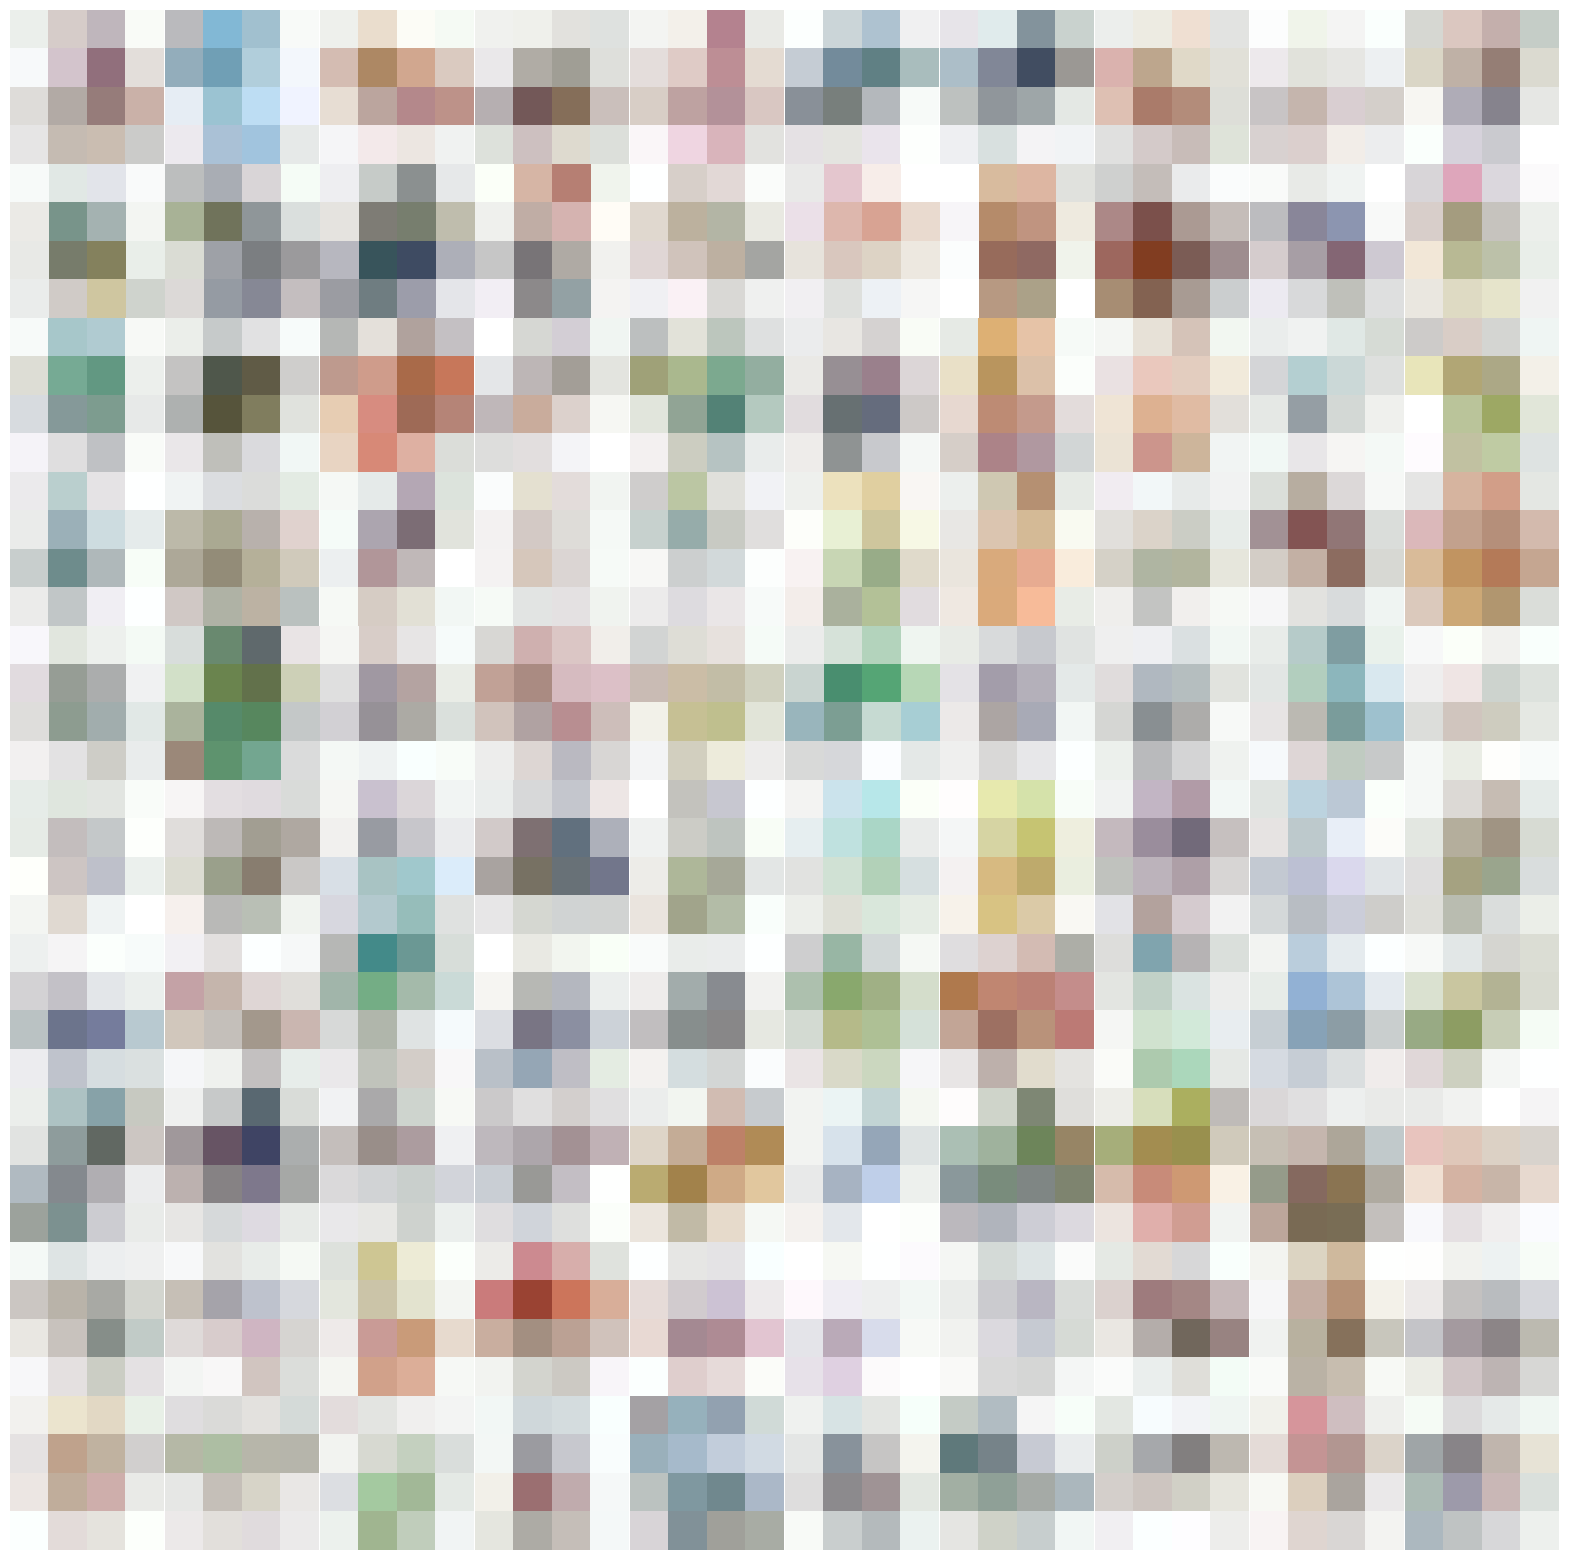

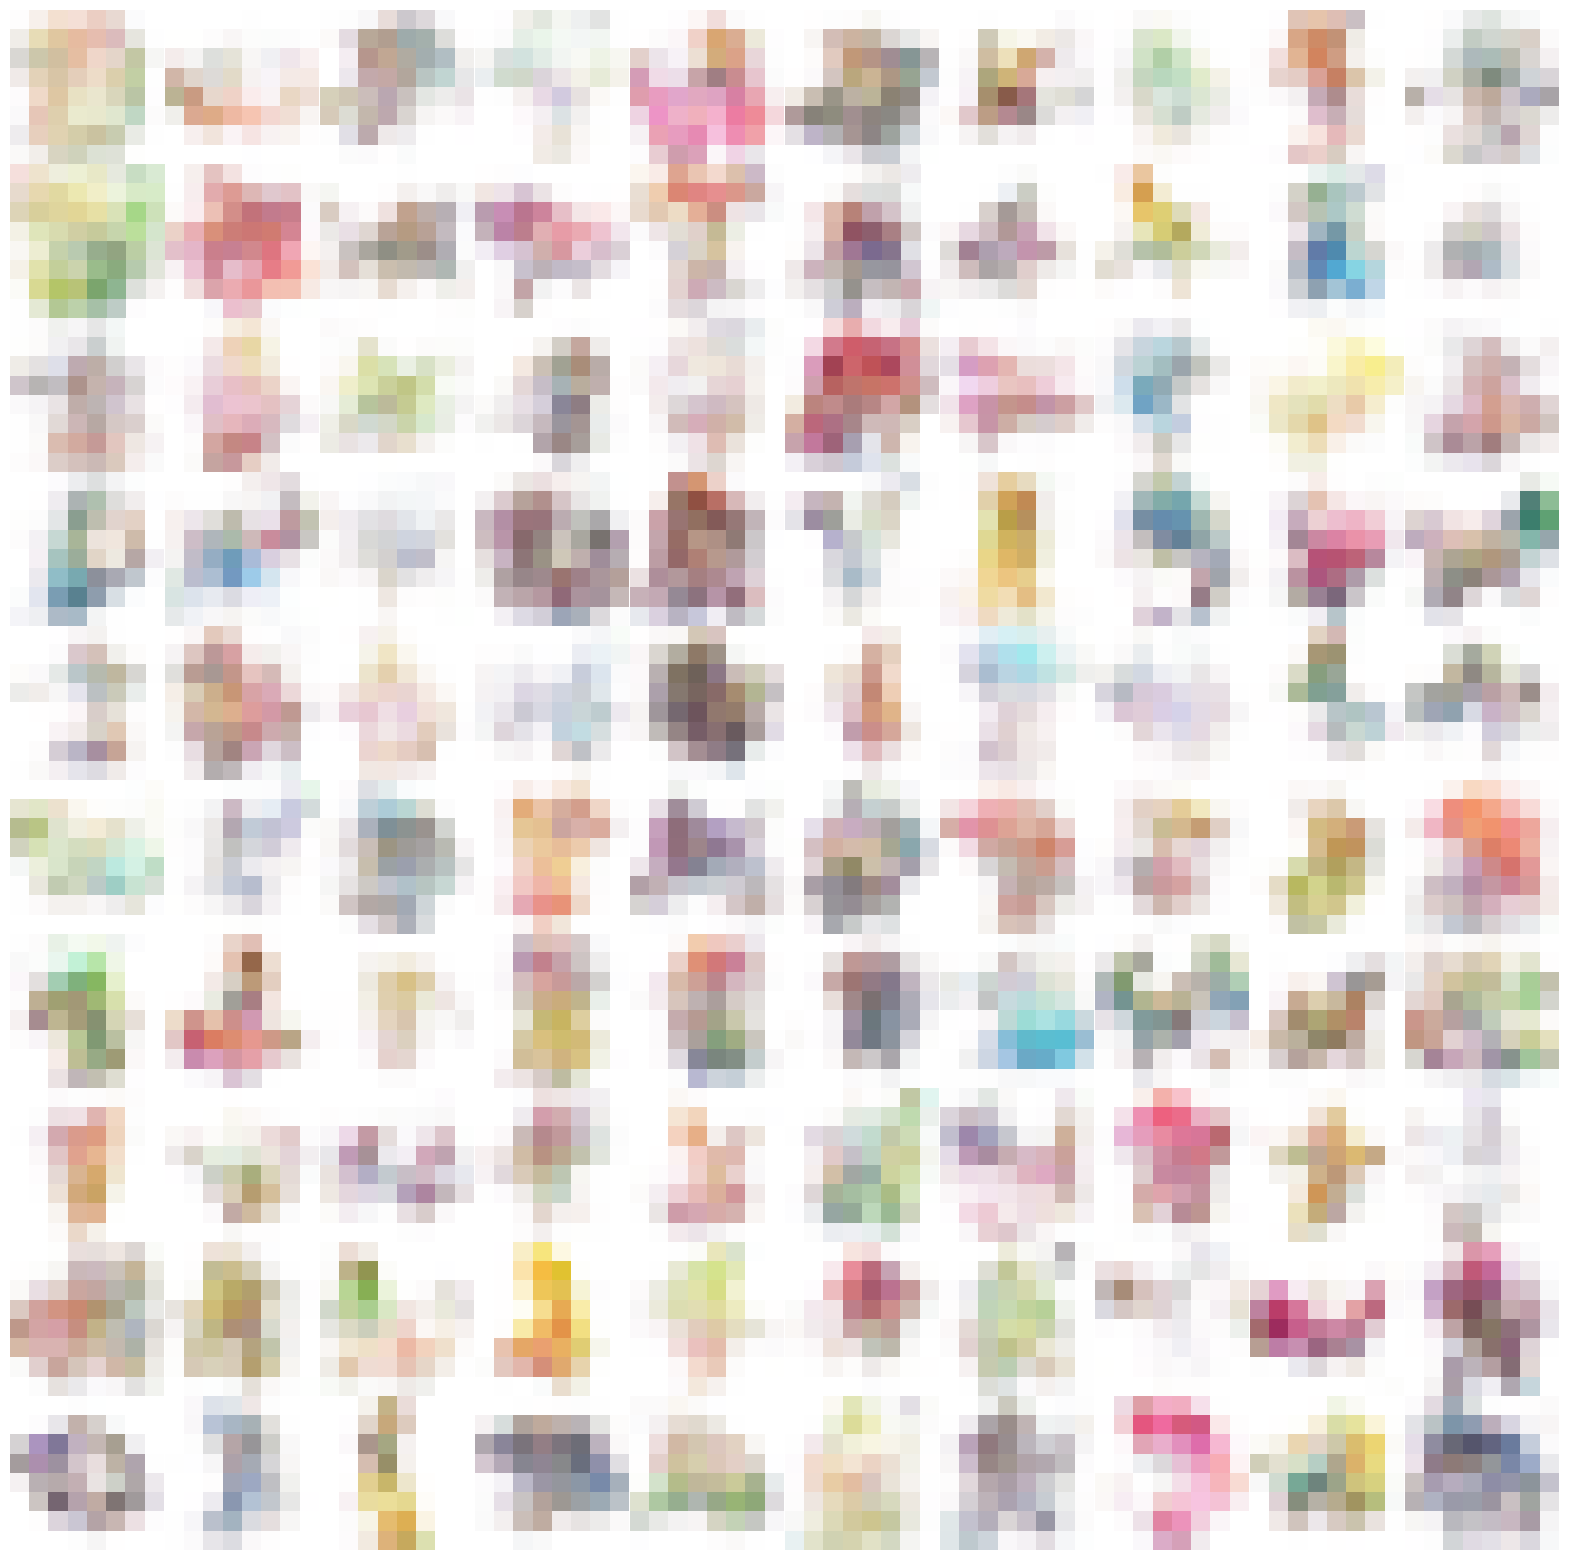

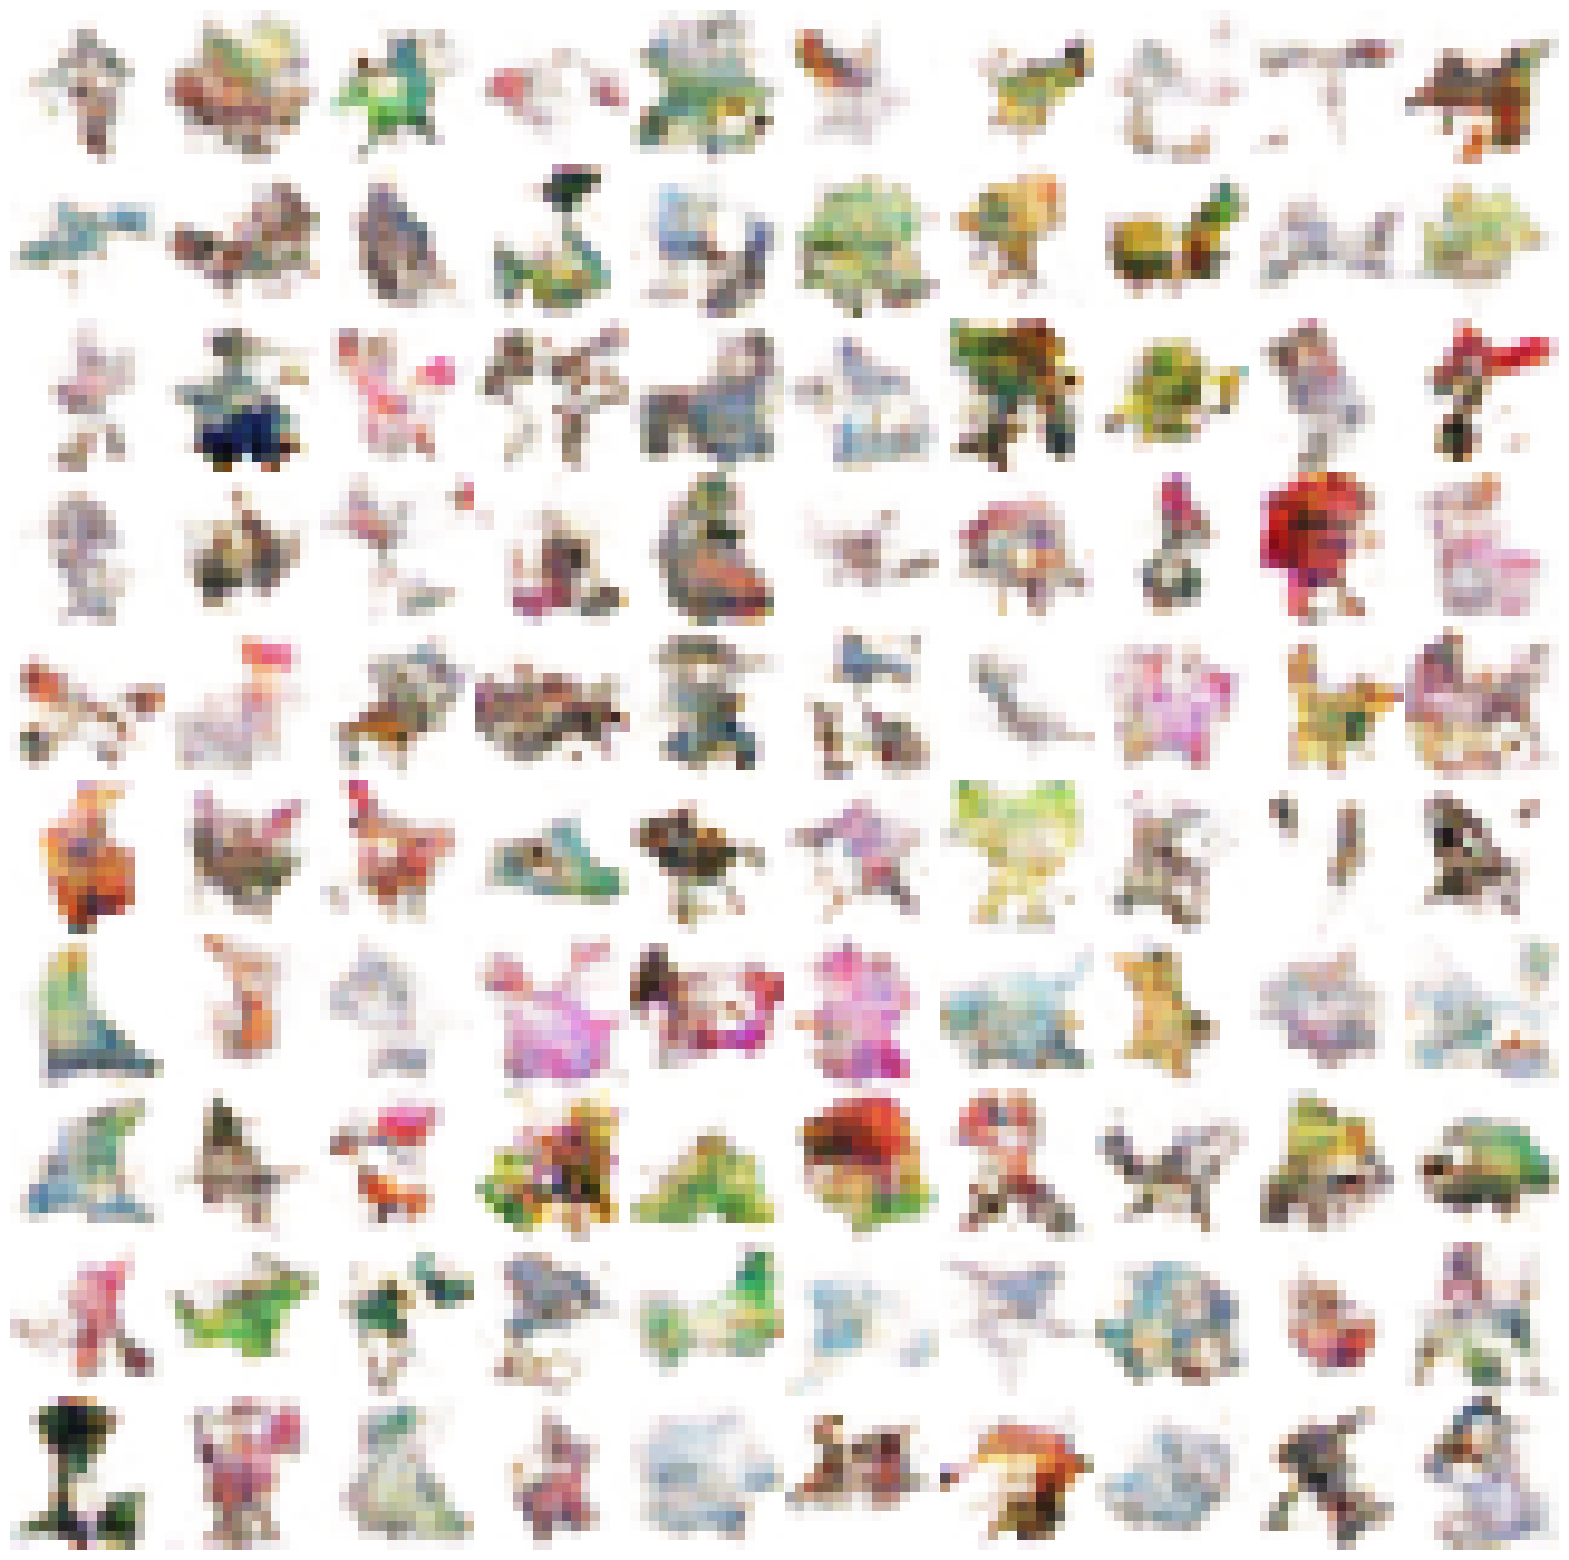

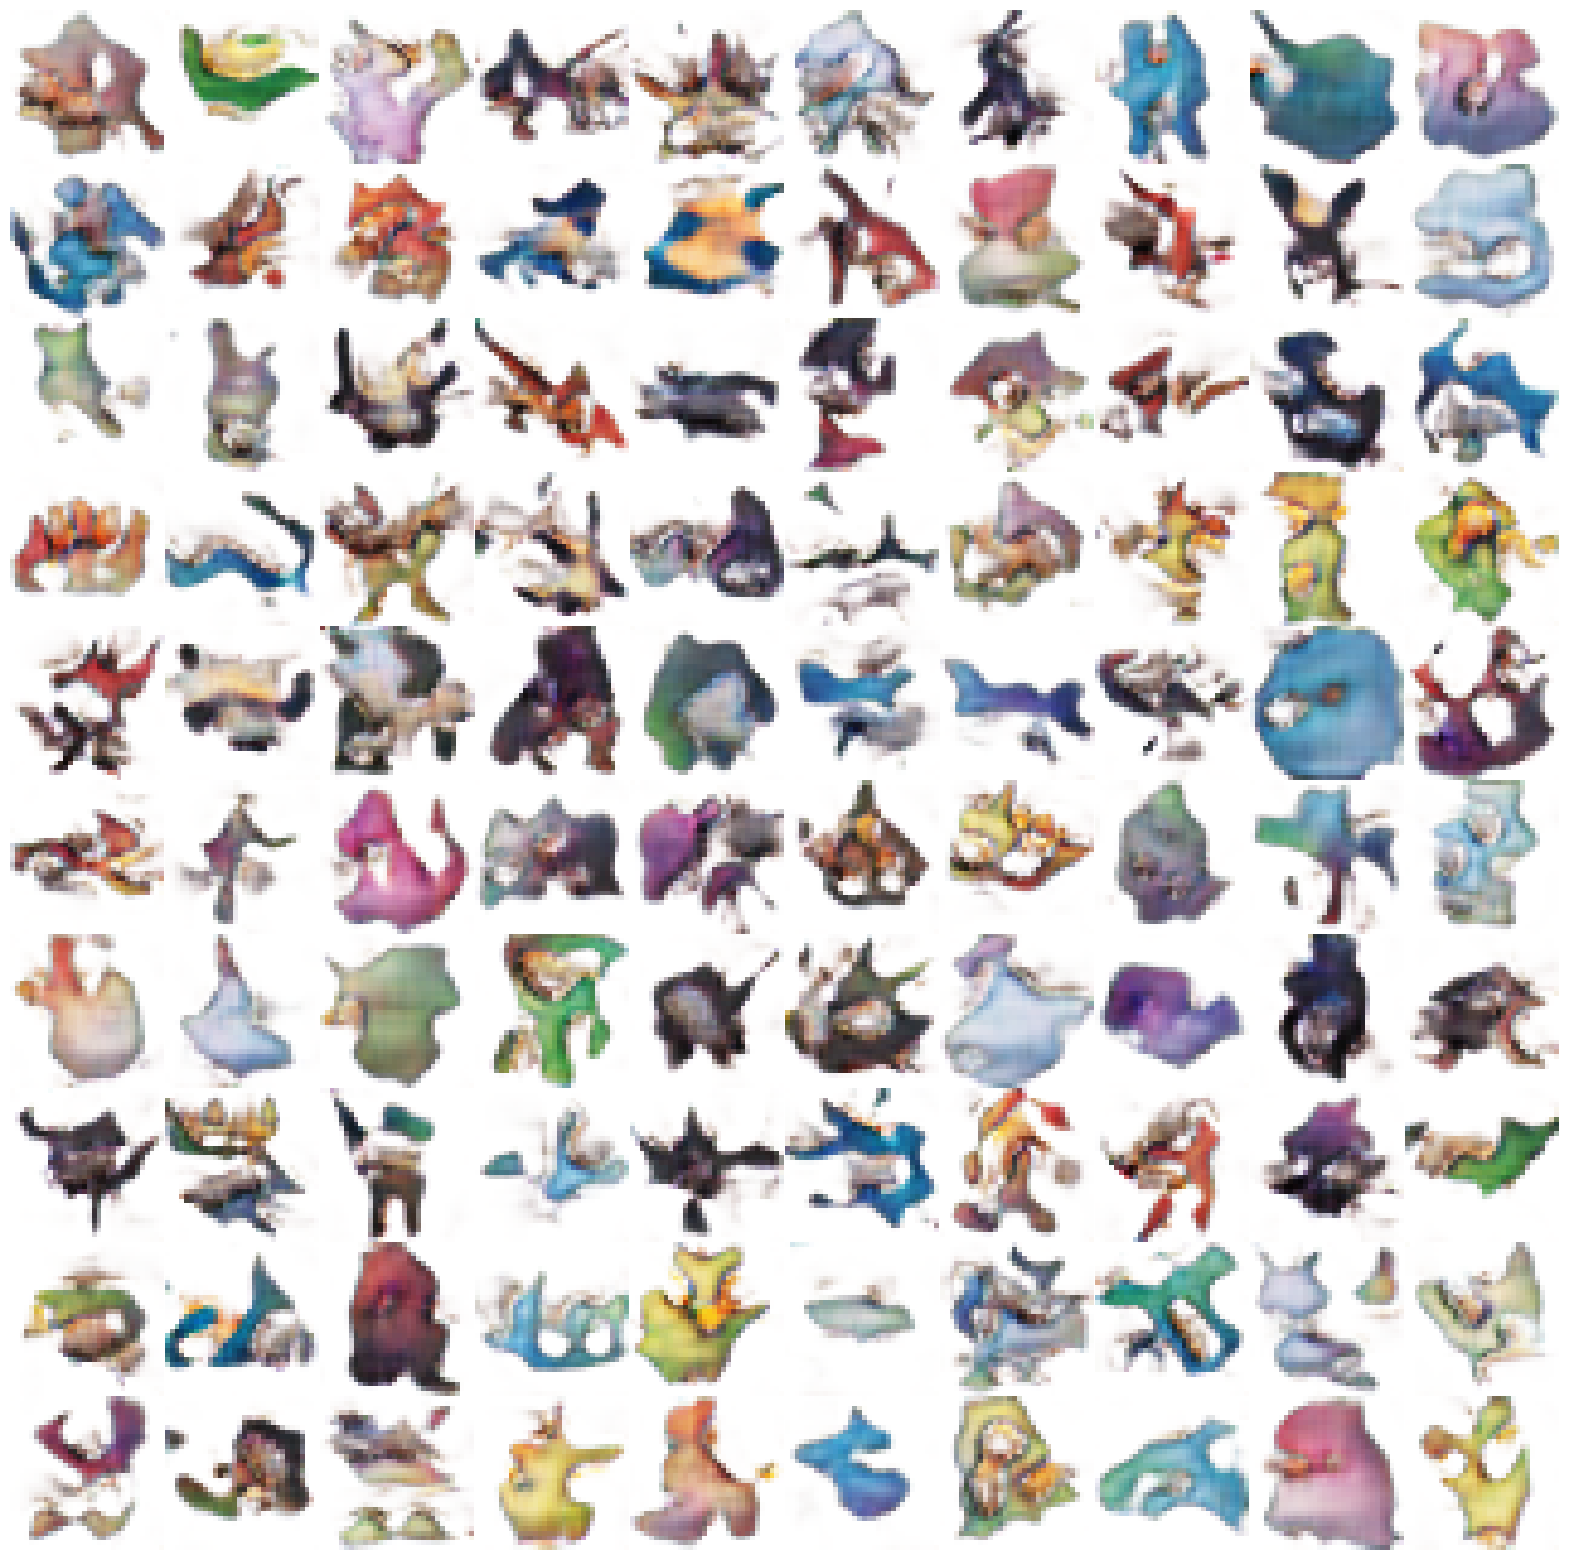

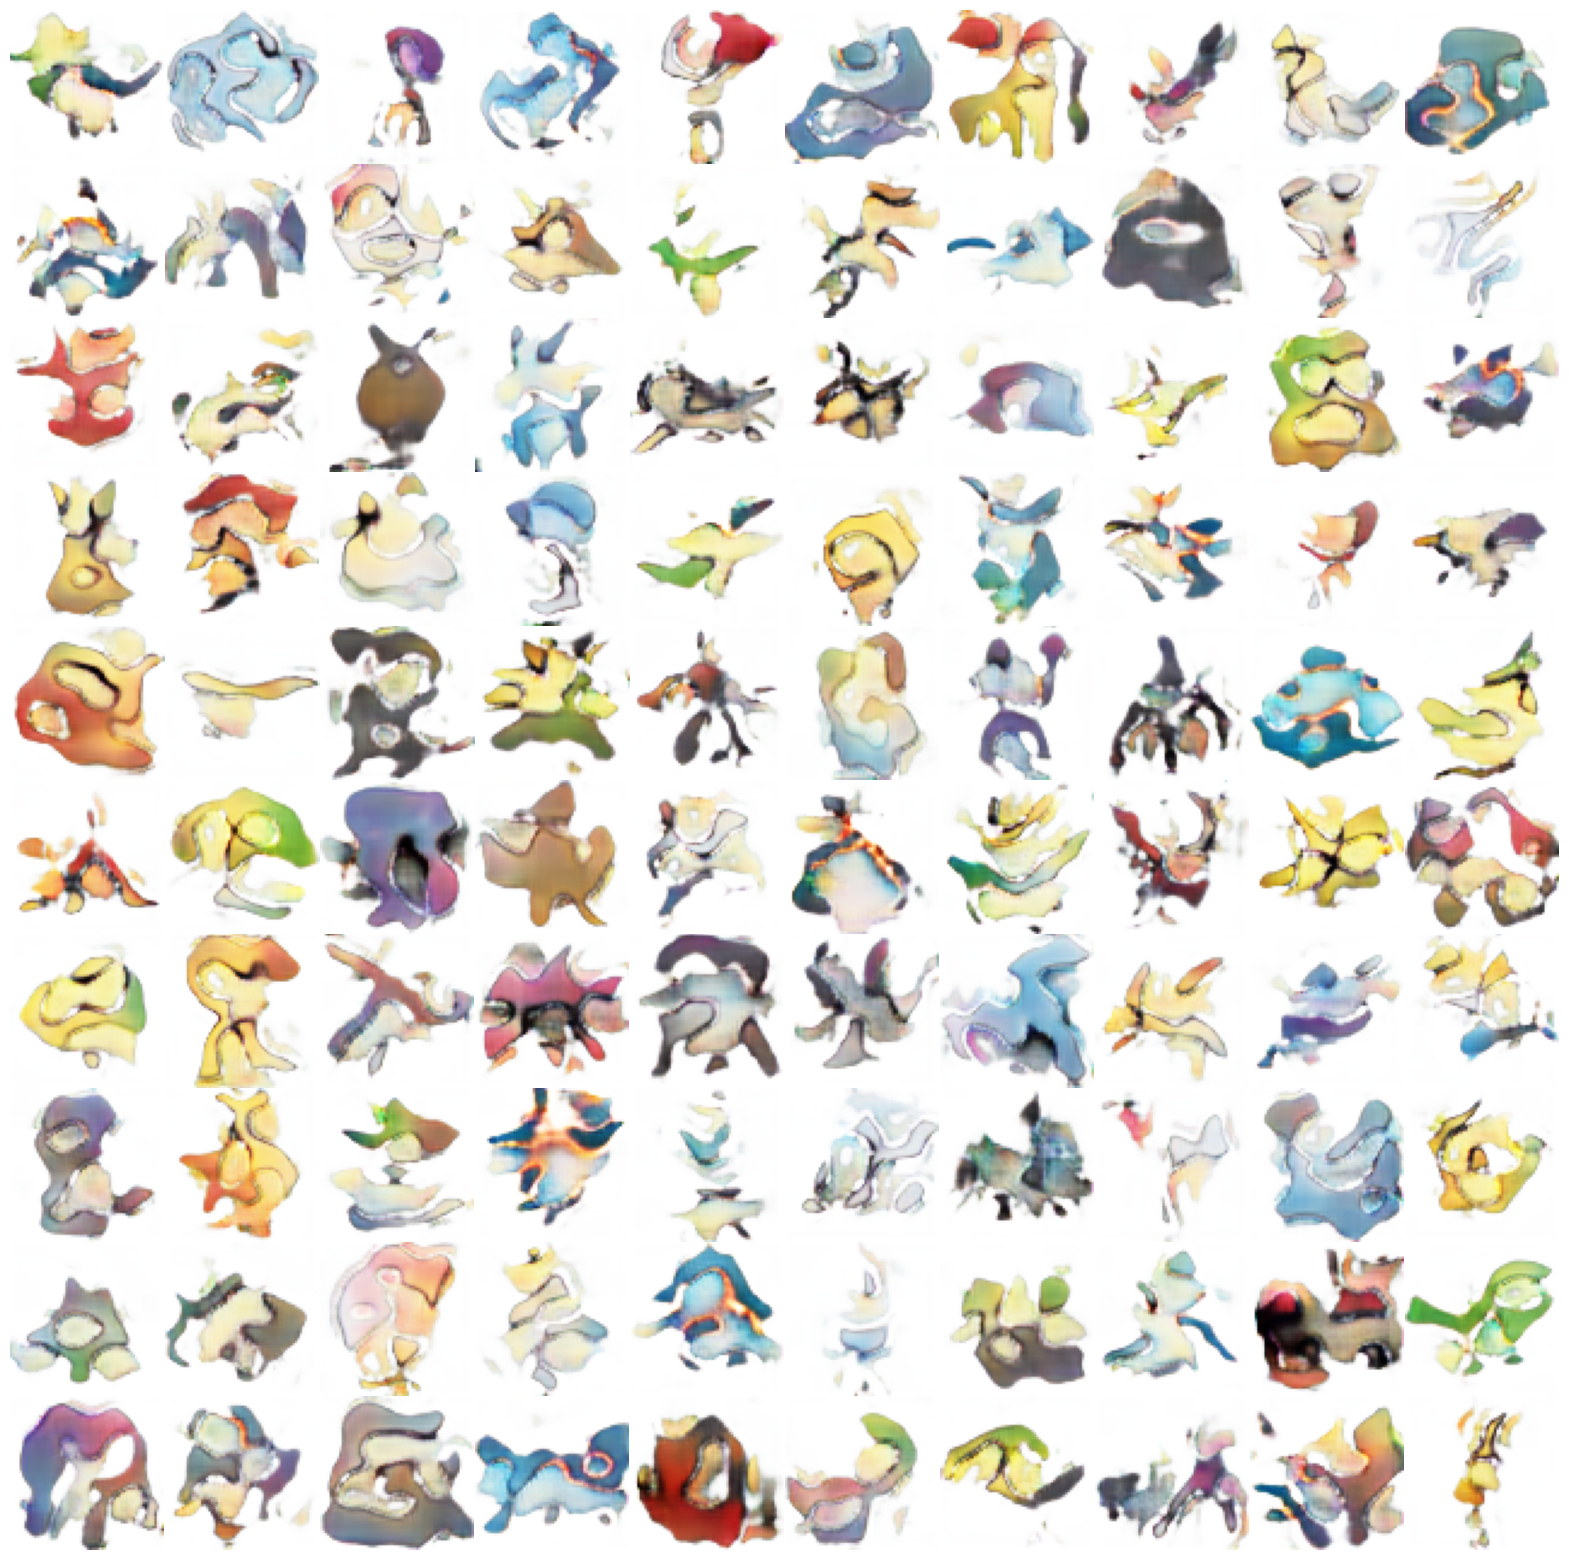

In [26]:
import matplotlib.pyplot as plt
from PIL import Image
import os

def load_images_from_folder(folder, num_images=100):
    images = []
    for i in range(0, num_images):
        filename = os.path.join(folder, f'img_{i}.png')
        try:
            img = Image.open(filename)
            images.append(img)
        except IOError:
            print(f"Error opening {filename}")
    return images

def plot_images(images, grid_size=(10, 10)):
    fig, axes = plt.subplots(nrows=grid_size[0], ncols=grid_size[1], figsize=(20, 20))
    axes = axes.flatten()
    
    for ax, img in zip(axes, images):
        ax.imshow(img)
        ax.axis('off')
    
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()

# Load and plot images for all steps
for step in range(0, 5):
    folder_path = rf'outputs/{EXPERIMENT_NAME}\step{step}'
    images = load_images_from_folder(folder_path)
    print(f"Loaded {len(images)} images from {folder_path}")
    plot_images(images)
